# CSC/XMM validation catalogs, XMM/CSC hostless catalog

In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
# plt.style.use('seaborn')

import seaborn as sns

from scripts.utils import set_mpl, data_path
from scripts.cross_match_scripts import cross_match_data_frames,  add_separation_columns
set_mpl()

%matplotlib inline
from astropy.table import Table

matplotlib settings set


matplotlib settings set
matplotlib settings set


In [3]:
def csc_error_converter(df: pd.DataFrame,
                        r0_colname='err_ellipse_r0',
                        r1_colname='err_ellipse_r1') -> pd.DataFrame:
    """
    The function converts default radii `r0_colname`
    and `r1_colname` to the one-sigma error.

    Args:
        df (pd.DataFrame): DataFrame with `r0_colname` and
        `r1_colname` columns.
        
        r0_colname (str): major radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r0'.
        
        r1_colname (str): minor radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r1'.

    Returns:
        pd.DataFrame: one-sigma error in arcseconds.
    """

    # Conversion coefficient
    csc_sigma_coeff = np.sqrt(-(1 / (2 * np.log(1 - .95))))

    err_r1 = df[r0_colname]
    err_r2 = df[r1_colname]
    # Effective error
    csc_err_eff = np.sqrt(err_r1 ** 2 + err_r2 ** 2)

    csc_1sigma = csc_sigma_coeff * csc_err_eff

    return csc_1sigma


def vot2pd_csc(csc_cat_path: str,
               colnames: list,
               save_coords: bool = False, 
               radec_fits_name: str = 'cscresults_name_radec') -> pd.DataFrame:
    """
    The function converts the votable file to pandas DataFrame.

    Optionally saves the separate file with the coordinates and names of
    the CSC sources to the FITS file.

    Args:
        csc_cat_path (str): the path to the votable file.
        colnames (list): column names of the votable file.
        save_coords (bool): if True, saves the separate file with the coordinates
        and names of the CSC sources to the FITS file.
        radec_fits_name (str): name of the FITS file with
        the coordinates and names of the CSC sources to be saved.

    Returns:
        pd.DataFrame: converted catalogue.
    """
    
    vot_table = Table.read(csc_cat_path, format='votable')
    
    df = vot_table.to_pandas()
    df.columns = colnames

    df = df.assign(flux_csc_05_2 = lambda x: x.flux_aper_s + x.flux_aper_m)

    one_sigma_errors = csc_error_converter(df)

    df = df.assign(radec_err_csc = one_sigma_errors)

    df['r_98_csc'] = tsource_r(sigma=df['radec_err_csc'], t_thresh=.02)

    if save_coords:

        df_init_coords = df[['name', 'ra', 'dec']]
        Table.from_pandas(df_init_coords).write(f'data/{radec_fits_name}.fits', format='fits')

    return df


def tsource_r(sigma: float, t_thresh: float) -> float:
    """
    Calculates the radius of circle which contains the probability `t_thresh`
    NOT to find a counterpart for a source with localization error `sigma`.

    Args:
        sigma (float): localization error in arcsec.
        t_thresh (float): probability to NOT find a counterpart.

    Returns:
        float: radius of circle in arcsec.
    """
    
    rsearch = sigma * np.sqrt(-2 * np.log(t_thresh))
    
    return rsearch


def fsource_r(rho: float, f_thresh: float) -> float:
    """
    The function calculates the radius which corresponds to the probability `f_thresh`
    to FIND one or more false sources. 

    Args:
        rho (float): the density of the false sources (in arcmin^{-2}).
        f_thresh (float): probability to FIND one or more false sources.

    Returns:
        float: radius (in arcsec).
    """

    rho = rho / 3600 # arcmin^{-2} -> arcsec^{-2}
    pf_r = np.sqrt(-1 / (rho * np.pi) * np.log(1 - f_thresh))
    
    return pf_r


def poserr2sigma_coeff(conf_level: float) -> float:
    """
    Calculates convertion coefficient to go from
    positional error to sigma given confidence level.

    For details see:
    https://www.notion.so/Theory-ca6e7795b40c43b4ba6d96bc59727efa#b4d9fc11ff8243a3834e9eeba08c2273
    """
    coeff = (-2 * np.log(1 - conf_level)) ** -0.5
    
    return coeff


def pos_r(sigma: float, conf_level: float) -> float:
    """
    Calculates the radius of circle which contains the probability `conf_level`
    of finding (opposite to tsource_r()) a counterpart for a source with
    localization error `sigma`.

    For details see:
    https://www.notion.so/Theory-ca6e7795b40c43b4ba6d96bc59727efa#0ba88df64d2d4d9583f93d63dbe1b927

    Args:
        sigma (float): localization error in arcsec.
        conf_level (float): probability of finding a counterpart.

    Returns:
        float: radius of circle in arcsec.
    """
    
    r_pos = sigma * np.sqrt(-2 * np.log(1 - conf_level))

    return r_pos


def only_reliable_xmm(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters out unreliable XMM sources.
    """
    reliable_df = df[
                    ((df['SC_SUM_FLAG'] == 0) |
                    (df['SC_SUM_FLAG'] == 1)) &
                    (df['SC_DET_ML'] > 10) &
                    ~(df['SC_VAR_FLAG'] == True) &
                    (df['SC_EXTENT'] == 0) &
                    (df['CONFUSED'] == False)
                    ]

    return reliable_df




def xray_filtration(df: pd.DataFrame,
                    DL_thresh: float = 6,
                    EL_thresh: float = 6,
                    verbouse=True) -> pd.DataFrame:
    """
    Filters X-ray sources.
    TODO: remake processing of duplicates
    """
    
    if verbouse:
        print(f'DET_LIKE_0 > {DL_thresh}')
        print(f'EXT_LIKE < {EL_thresh}')
        print()

        print(f'Before X-ray source filters: {len(df)}')

    df = df[(df['DET_LIKE_0'] > DL_thresh)&
            (df['EXT_LIKE'] < EL_thresh)]

    if verbouse:
        print(f'After X-ray source filters: {len(df)}')
        print()


    # Manually get rid of faint sources in duplicated pairs
    df = df[~((df['srcname_fin']=='SRGe J104659.3+573056')&(df['DET_LIKE_0'] < 20))]
    df = df[~((df['srcname_fin'] == 'SRGe J104700.7+574558')&(df['DET_LIKE_0'] < 20))]
    print('Weak ERO duplicates removed (temporary measure)')
    print()

    return df



srg_names = {
            'id_src_name': 'srcname_fin',  # Индексы рентгеновских источников
            'x_ra_name': 'RA_fin',  # Координаты рентгеновских источников
            'x_dec_name': 'DEC_fin',
            'dl_name': 'DET_LIKE_0',  # Detection Likelihood
            'x_flux_name': 'flux_05-20',
            'ext_name': 'EXT_LIKE',  # Протяженность рентгеновских источников
            'ls_ra_name': 'ra',  # Координаты источников DESI
            'ls_dec_name': 'dec',
            'r_98_name': 'pos_r98',  # Позиционная ошибка
            'sigma_2d_name': 'pos_sigma_2d'
            }


***

In [4]:
# Каталог ERO (9500)
ero_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl') #TODO note the ero catalog that you are using!
#ero_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_orig.pkl') 
ero_df = xray_filtration(ero_df, DL_thresh=6, EL_thresh=6)
ero_df.sample(5)

DET_LIKE_0 > 6
EXT_LIKE < 6

Before X-ray source filters: 9215
After X-ray source filters: 9215

Weak ERO duplicates removed (temporary measure)



,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH
4200,SRGe J105015.6+591852,162.564932,59.314373,147.448594,51.656011,5.805031,31.545288,8.159685e-15,1.680179e-15,39.139217,8.059244,4382.140137,0.0,0.0,0.0,5090,4148,162.566941,59.313084,2.452896,136.229645,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.008932,0.001839,18.826580,162.564932,59.314373,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.0,0,1,1,0,17.118999,16.320000,12.625,9.2,5.1,-1.3,1,1,0,1237658304890340137,0,4.138851,57732666688,2.452896,2.075338,3.132914,5.079902,135.266697,46.735181,6.279196e-15,8.017584e+19
2439,SRGe J105154.9+553433,162.978811,55.575698,151.811350,54.328272,9.264550,11.533067,1.325346e-14,4.140296e-15,19.361738,6.048484,1334.635376,0.0,0.0,0.0,6440,5360,162.980819,55.574409,4.056958,121.720406,0.000017,6.268413e+08,6.270701e+08,0.0,0.0,0.014507,0.004532,12.274200,162.978811,55.575698,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.0,0,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1237657221486609748,0,8.719342,72207564264,4.056958,3.312140,4.999980,8.107279,138.398999,43.707871,1.019905e-14,9.130086e+19
4658,SRGe J103411.7+562614,158.548899,56.437202,153.227567,51.848182,8.374248,19.356266,7.376971e-15,1.744209e-15,34.664833,8.196143,4292.977051,0.0,0.0,0.0,5346,4368,158.550907,56.435912,3.648761,96.707397,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.008075,0.001909,22.236614,158.548899,56.437202,853927566750825728,2.138616,3,2,17.370947,NaN,0,NaN,NaN,NaN,-1.0,0,0,0,0,12.593000,12.615000,11.934,48.1,46.1,4.4,3,6,1,1237655107298000949,0,1.862625,68741084710,3.648761,2.993850,4.519493,7.328187,134.866524,43.164607,5.676867e-15,5.650625e+19
617,SRGe J104129.6+584602,160.373529,58.767354,149.309628,51.183686,3.532682,272.287628,3.703999e-14,3.202852e-15,173.086456,14.966805,4269.133301,0.0,0.0,0.0,594,492,160.375538,58.766064,1.329164,92.666008,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.040544,0.003506,18.660688,160.373529,58.767354,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.0,0,0,0,0,17.474001,17.186001,12.635,8.0,2.8,0.4,1,1,0,1237658304889815450,0,6.421294,59756972937,1.329164,1.262958,1.906551,3.091401,134.331731,45.662276,2.850372e-14,7.663713e+19
9079,SRGe J104253.1+550215,160.721410,55.037370,153.893230,53.662734,8.051209,14.425643,2.877855e-15,7.803321e-16,25.838356,7.006086,8202.448242,0.0,0.0,0.0,7241,6118,160.723419,55.036081,3.500096,104.889839,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.003150,0.000854,32.854618,160.721410,55.037370,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.0,0,0,0,0,16.625999,16.653000,12.198,13.9,4.5,1.1,1,1,0,1237657770712892415,0,8.678091,74413062881,3.500096,2.878362,4.345153,7.045502,137.274994,42.581817,2.214621e-15,8.044204e+19


In [5]:
# desi_lh.gz_pkl number of sources and area
false_dens_arcmin = 2418574 / (41.729 * 3600)
print(false_dens_arcmin)
false_dens_arcsec = false_dens_arcmin / 3600

print(f'{ false_dens_arcsec:.3f}')

FALSE_PROB = .03

r_false = fsource_r(false_dens_arcmin, FALSE_PROB)

print(f'Радиус для {FALSE_PROB:.0%} вероятности найти ложный: {r_false:.2f}"')

desi = pd.read_pickle(data_path+'desi_lh.gz_pkl', compression='gzip')
desi.sample(5)

16.099741453452303
0.004
Радиус для 3% вероятности найти ложный: 1.47"


,release,objid,brickid,ra,dec,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,dered_mag_w3,dered_mag_w4,snr_g,snr_r,snr_z,snr_w1,snr_w2,snr_w3,snr_w4,type,parallax,parallax_ivar,pmra,pmra_ivar,pmdec,pmdec_ivar,ref_cat,ref_id,mjd_max,mjd_min,iso_max,iso_min,desi_id
1177229,9011,2905,612247,157.650557,58.187127,0.314470,0.714148,1.010381,0.527940,-1.134458,22.287971,99.613470,388.82610,103.582010,26.725998,4.251734,1.035485,0.001347,0.000017,23.721240,22.842080,22.475670,23.191545,NaN,19.129562,17.504107,6.200931,7.268260,5.223384,1.088599,-1.154411,0.817921,0.410094,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.395665,57820.345139,2018-03-17 09:29:45.430,2017-03-08 08:17:00.000,9011_612247_2905
825194,9011,1469,612265,166.007609,58.265627,0.365615,0.306574,0.348794,0.349896,-0.300424,47.051820,109.579370,320.68808,246.241400,135.497590,4.562877,1.196859,0.000985,0.000012,23.562012,23.763163,23.632110,23.638410,NaN,18.318330,17.400590,6.547340,4.810790,4.060085,0.747409,-0.328667,1.476569,0.382313,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,57919.198623,57545.197768,2017-06-15 04:46:01.000,2016-06-06 04:44:47.170,9011_612265_1469
327119,9011,2172,619600,159.968172,60.716731,0.520134,0.704375,0.839374,2.303432,5.306988,-75.415955,-119.288124,436.65546,193.994320,40.438835,4.532882,1.077814,0.000893,0.000011,23.176790,22.858313,22.677706,21.592176,20.686722,NaN,NaN,10.868880,9.810671,5.337709,4.904137,5.509600,-2.253326,-0.387988,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58226.271131,57414.406030,2018-04-18 06:30:25.741,2016-01-27 09:44:41.000,9011_619600_2172
2151561,9011,1458,608371,156.861847,57.036616,0.380454,0.465186,0.806093,0.600607,0.626906,37.425780,-48.416940,524.67004,259.964720,129.544900,4.294511,1.053596,0.001359,0.000017,23.526203,23.315413,22.725355,23.052206,23.006184,18.566900,NaN,8.714550,7.500392,9.174772,1.244650,0.643486,1.379856,-0.197513,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.392789,57824.398484,2018-03-17 09:25:36.961,2017-03-12 09:33:49.000,9011_608371_1458
1421524,9011,2447,607581,157.655574,56.731044,0.768682,0.347164,2.022993,1.672812,2.102938,-19.455317,16.003195,64.31570,12.857048,3.727500,2.896004,0.729008,0.001050,0.000015,22.768373,23.637037,21.728510,21.940393,21.692327,NaN,19.489435,6.164607,1.244815,3.905740,2.846732,1.795531,-0.630368,0.062491,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.392789,57784.428207,2018-03-17 09:25:36.961,2017-01-31 10:16:37.100,9011_607581_2447


# CSC

In [6]:
# CSC table conversion
csc_columns = ['name', 'ra', 'dec', 'err_ellipse_r0', 'err_ellipse_r1', 'err_ellipse_ang',
               'significance', 'likelihood', 'likelihood_class', 'conf_flag', 'dither_warning_flag',
               'extent_flag', 'pileup_flag', 'sat_src_flag', 'streak_src_flag', 'var_flag',
               'flux_aper_s', 'flux_aper_lolim_s', 'flux_aper_hilim_s', 'flux_aper_m',
               'flux_aper_lolim_m', 'flux_aper_hilim_m']

# Filtration
# data/cscresults.vot obtained via CSCview software
csc_init_df = vot2pd_csc(csc_cat_path=data_path+'cscresults.vot', colnames=csc_columns)

# CSC catalogue filtering
csc_df = csc_init_df[(csc_init_df['conf_flag'] == False) &
                              (csc_init_df['extent_flag'] == False) &
                              (csc_init_df['sat_src_flag'] == False) &
                              (csc_init_df['streak_src_flag'] == False) &
                              (csc_init_df['pileup_flag'] == False) &
                              (csc_init_df['dither_warning_flag'] == False)]


csc_df = csc_df[(csc_df['likelihood'] > 10) &
                                  (csc_df['likelihood'] < 10 ** 10)]


csc_df = csc_df.assign(flux_05_2 = lambda x: x.flux_aper_s + x.flux_aper_m)

# Ошибки на поток 0.5-2 кэВ
s_up = csc_df.flux_aper_hilim_s - csc_df.flux_aper_s
s_down = csc_df.flux_aper_s - csc_df.flux_aper_lolim_s
s_err = np.sqrt(s_up ** 2 + s_down ** 2)
m_up = csc_df.flux_aper_hilim_m - csc_df.flux_aper_m
m_down = csc_df.flux_aper_m - csc_df.flux_aper_lolim_m
m_err = np.sqrt(m_up ** 2 + m_down ** 2)

sm_err = np.sqrt(s_err ** 2 + m_err ** 2).values
csc_df['flux_aper_sm_err'] = sm_err


print(f'CSC Sources: {csc_df.shape[0]}')
csc_df.sample(5)


CSC Sources: 267265


,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood,likelihood_class,conf_flag,dither_warning_flag,extent_flag,pileup_flag,sat_src_flag,streak_src_flag,var_flag,flux_aper_s,flux_aper_lolim_s,flux_aper_hilim_s,flux_aper_m,flux_aper_lolim_m,flux_aper_hilim_m,flux_csc_05_2,radec_err_csc,r_98_csc,flux_05_2,flux_aper_sm_err
19998,2CXO J012338.5-481700,20.910552,-48.283358,1.093225,1.016275,144.675585,1.837838,12.913554,MARGINAL,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.609799,1.705700,NaN,NaN
225472,2CXO J170047.1-461357,255.196651,-46.232777,1.890378,1.890378,0.000000,2.734694,21.760686,TRUE,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,6.695076e-17,1.129029e-16,3.225796e-17,1.935478e-16,1.129029e-16,1.092187,3.055011,1.129029e-16,1.322483e-16
278661,2CXO J193118.5-034314,292.827317,-3.720742,1.063546,0.909720,48.641630,2.722222,30.602381,TRUE,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,5.028603e-16,1.403377e-15,6.827237e-16,2.086100e-15,1.403377e-15,0.571768,1.599320,1.403377e-15,1.112799e-15
304081,2CXO J223511.3-254912,338.797202,-25.820115,1.470187,0.949908,5.540848,8.442886,156.553142,TRUE,False,False,False,False,False,False,False,1.561826e-15,1.021194e-15,2.072423e-15,1.434597e-15,9.990942e-16,1.870099e-15,2.996423e-15,0.715092,2.000219,2.996423e-15,9.655657e-16
295797,2CXO J212800.3+565150,322.001332,56.863964,3.288644,2.013703,91.578290,3.052632,82.497076,TRUE,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.575403,4.406638,NaN,NaN


In [7]:
csc_df.to_pickle(data_path+'csc_cleared.pkl')


## CSC x ERO cross-match

In [8]:
ero_csc = cross_match_data_frames(ero_df, csc_df,
 'RA_fin', 'DEC_fin', 'ra', 'dec', match_radius = 30, df_prefix = 'csc')
 
ero_csc = ero_csc.query("csc_n_near==1 & csc_n_matches==1")
print('cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source', ero_csc.shape[0])

assert len(ero_csc) == ero_csc.csc_name.nunique()
ero_csc.sample(5)

cross-match radius 30 arcsec
total matches: 739 out of 9215 x 267265
	 total unique pairs: 692
	 total non-unique pairs (duplicates in df2): 47
cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source 566


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches
611,SRGe J105112.0+572632,162.799882,57.442294,149.555561,53.020991,8.066554,10.693303,4.486669e-15,1.390240e-15,20.805161,6.446688,4236.376465,0.0,0.0,0.0,8719,7567,162.801890,57.441004,3.507166,74.937355,0.000008,6.268413e+08,6.270701e+08,0.0,0.0,0.004911,0.001522,18.475985,162.799882,57.442294,-1,-1.000000,0,-1,NaN,-1.0,-1,ISO-LHDS J105112+572629,NaN,Galaxy,2.114442,2,1,0,0,17.304001,16.826000,12.454,8.9,1.9,0.9,1,2,0,1237658302742659612,0,5.835775,64795645672,3.507166,2.883848,4.353434,7.058929,136.888010,45.234832,3.452667e-15,6.600567e+19,2CXO J105111.7+572634,162.799002,57.442994,0.863460,0.821149,41.259254,2.722222,150.809798,TRUE,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.486804,1.361665,NaN,NaN,3.044063,1,1
33,SRGe J105209.4+565342,163.039215,56.894958,150.089474,53.484001,2.994970,463.113678,5.503385e-14,3.877604e-15,251.880264,17.747114,4181.304199,0.0,0.0,0.0,324,274,163.041224,56.893669,1.031325,44.906925,0.000004,6.268413e+08,6.270701e+08,0.0,0.0,0.060240,0.004244,19.911879,163.039215,56.894958,851163325798128640,5.976887,1,0,20.428961,-1.0,0,SDSS J105209.41+565341.6,1.734181,QSO,5.973719,1,1,1,1,16.141001,15.004000,12.289,20.1,16.8,2.8,1,1,1,1237655106762179059,9207767342700056576,5.936629,66931125717,1.031325,1.070722,1.616354,2.620856,137.459593,44.843316,4.235069e-14,6.873125e+19,2CXO J105209.4+565341,163.039259,56.894927,1.602780,1.302019,46.669098,4.457143,81.228058,TRUE,False,False,False,False,False,False,False,1.286215e-14,8.038844e-15,1.768546e-14,1.412050e-14,9.324858e-15,1.864972e-14,2.698265e-14,0.843626,2.359749,2.698265e-14,9.488970e-15,0.141856,1,1
615,SRGe J104803.5+592435,162.014726,59.409758,147.646288,51.386593,8.192696,9.526644,4.439474e-15,1.408344e-15,20.716311,6.571881,4263.128418,0.0,0.0,0.0,8511,7363,162.016734,59.408469,3.565251,68.329102,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.004859,0.001542,22.104664,162.014726,59.409758,-1,-1.000000,0,-1,NaN,-1.0,-1,CLANS 674,NaN,X,8.765576,2,1,0,1,17.378000,16.534000,12.655,7.7,4.7,-0.2,1,1,0,1237655368746205694,0,8.043069,57382522600,3.565251,2.928944,4.421512,7.169314,134.849098,46.659774,3.416348e-15,8.323205e+19,2CXO J104803.1+592433,162.012976,59.409340,1.859415,1.293034,102.401879,3.575758,39.063538,TRUE,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,3.197546e-15,0.000000e+00,0.000000e+00,9.849665e-16,0.000000e+00,0.925263,2.588099,0.000000e+00,3.345812e-15,3.541433,1,1
308,SRGe J104850.0+571006,162.208538,57.168301,150.248365,52.964389,5.917938,40.364368,9.604319e-15,1.817933e-15,43.983997,8.325417,4183.845215,0.0,0.0,0.0,3474,2764,162.210547,57.167011,2.506354,175.908646,0.000010,6.268413e+08,6.270701e+08,0.0,0.0,0.010513,0.001990,17.300806,162.208538,57.168301,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,1,16.867001,15.857000,12.319,12.9,9.1,1.7,1,0,-1,0,0,NaN,65860508305,2.506354,2.115703,3.193849,5.178705,136.714807,44.832193,7.390899e-15,6.904034e+19,2CXO J104850.0+571001,16

## CSC x DESI cross-match

In [9]:
csc_desi_all = cross_match_data_frames(ero_csc, desi, colname_ra1 = 'csc_ra',colname_dec1 = 'csc_dec' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')
csc_desi_all

cross-match radius 15 arcsec
total matches: 2543 out of 566 x 2418574
	 total unique pairs: 2543
	 total non-unique pairs (duplicates in df2): 0


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
2,SRGe J110242.6+594120,165.677384,59.688978,145.179791,52.486946,7.653812,211.181183,1.846204e-13,1.864554e-14,134.683884,13.602254,666.474426,0.0,0.0,0.0,679,556,165.679392,59.687689,3.316714,224.252457,0.000026,6.268413e+08,6.270701e+08,0.0,0.0,0.202084,0.020409,3.928642,165.677384,59.688978,860692071522063104,4.485168,1,0,17.027691,-1.0,0,6C 105938+595728,1.83,BLLac,4.485268,1,1,1,1,13.617000,12.659000,9.803,43.9,47.2,27.9,1,3,1,1237658304891060264,0,3.087692,56364004534,3.316714,2.736290,4.130682,6.697745,136.878443,47.936061,1.420726e-13,6.398279e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,2.196054e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,2.779278,1,1,9011,4152,616737,165.678178,59.688774,123.783880,140.066150,194.811190,287.176500,388.446700,1089.463000,2591.550300,53.469475,22.336110,17.090487,1.092097,0.326052,0.001556,0.000019,17.247953,17.120436,16.768284,16.353460,16.025955,14.906816,13.966043,905.142700,661.967900,805.361940,300.109280,221.806760,42.980423,11.174195,PSF,-0.023313,140.88054,-0.008907,94.32313,0.07499,50.308243,G2,860692071522063104,58194.477145,57813.360879,2018-03-17 11:27:05.369,2017-03-01 08:39:39.978,9011_616737_4152,2.540902,7,1
1,SRGe J110242.6+594120,165.677384,59.688978,145.179791,52.486946,7.653812,211.181183,1.846204e-13,1.864554e-14,134.683884,13.602254,666.474426,0.0,0.0,0.0,679,556,165.679392,59.687689,3.316714,224.252457,0.000026,6.268413e+08,6.270701e+08,0.0,0.0,0.202084,0.020409,3.928642,165.677384,59.688978,860692071522063104,4.485168,1,0,17.027691,-1.0,0,6C 105938+595728,1.83,BLLac,4.485268,1,1,1,1,13.617000,12.659000,9.803,43.9,47.2,27.9,1,3,1,1237658304891060264,0,3.087692,56364004534,3.316714,2.736290,4.130682,6.697745,136.878443,47.936061,1.420726e-13,6.398279e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,2.196054e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,2.779278,1,1,9011,4143,616737,165.676791,59.691063,-0.015934,0.072536,0.596225,3.677433,6.544

In [10]:
csc_desi = csc_desi_all.query("desi_sep<=1.1*csc_r_98_csc") #of you want only sep < r_false and the only one, replace 1.1*csc_r_98_csc with @r_false
#desi within 1.1*csc_r_98_csc and the only one
group = csc_desi.groupby('csc_name')['desi_desi_id'].count()
single_idxes = group[group == 1].index
csc_desi = csc_desi[csc_desi['csc_name'].isin(single_idxes)]


#csc_desi = csc_desi_all.query("desi_sep<=@r_false")
csc_desi = csc_desi.query("desi_sep<=@r_false")

print('cross-matches: only one desi within r_false and it is unique', csc_desi.shape[0])

 

csc_desi['csc_ero_flux_ratio'] = csc_desi['csc_flux_csc_05_2'] / csc_desi['flux_05-20']

csc_desi.sample(5)


cross-matches: only one desi within r_false and it is unique 372


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches,csc_ero_flux_ratio
1268,SRGe J103348.5+574715,158.451935,57.787622,151.532531,51.005811,7.231933,26.610662,8.303148e-15,1.780802e-15,39.033646,8.371665,4294.808594,0.0,0.0,0.0,3872,3095,158.453944,57.786332,3.121334,114.892868,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.009089,0.001949,18.971720,158.451935,57.787622,-1,-1.000000,0,-1,NaN,-1.0,-1,CLASXS 268,1.026000,AGN,10.635569,1,1,0,0,16.853001,16.813,12.430,12.7,3.9,1.2,1,1,0,1237655108908810628,0,4.116857,63464113800,3.121334,2.585465,3.902998,6.328564,133.846618,44.297454,6.389596e-15,5.674937e+19,2CXO J103348.1+574719,158.450465,57.788857,0.721803,0.717353,115.636710,8.564529,433.739547,TRUE,False,False,False,False,False,False,True,2.620861e-15,2.176283e-15,3.039288e-15,2.350807e-15,2.003154e-15,2.678010e-15,4.971668e-15,0.415746,1.162905,4.971668e-15,7.750190e-16,5.265747,1,1,9011,2748,610715,158.450455,57.788845,1.541294,1.761110,3.073198,11.546273,10.784979,9.884365,-156.30426,663.53790,225.64186,82.572540,4.211205,1.076993,0.001541,0.000018,22.016413,21.876188,21.275797,19.843102,19.917463,20.012524,NaN,39.702534,26.454310,27.925978,23.694363,11.192464,0.387986,-0.668001,PSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.395665,57842.283783,2018-03-17 09:29:45.430,2017-03-30 06:48:38.810,9011_610715_2748,0.046995,5,1,0.778088
78,SRGe J103440.0+574355,158.666611,57.732003,151.493369,51.130725,2.868944,612.382446,6.337805e-14,4.004150e-15,300.247955,18.969309,4328.014160,0.0,0.0,0.0,237,197,158.668620,57.730713,0.956876,116.449554,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.069373,0.004383,19.187504,158.666611,57.732003,854824282906636544,6.917654,1,0,20.824614,-1.0,0,2XMM J103439.8+574355,0.451227,QSO,6.893005,1,1,0,1,15.264000,14.436,11.543,30.7,24.2,7.0,1,2,0,1237655108908810471,7980580411771473920,7.042223,63678056154,0.956876,1.025667,1.548339,2.510573,134.023771,44.309107,4.877189e-14,5.741597e+19,2CXO J103439.8+574355,158.666206,57.732097,0.727052,0.723881,37.116559,14.781488,1306.861205,TRUE,False,False,False,False,False,False,True,8.740704e-15,7.917488e-15,9.563921e-15,9.754971e-15,8.983128e-15,1.048141e-14,1.849568e-14,0.419148,1.172418,1.849568e-14,1.574430e-15,0.848898,1,1,9011,937,610716,158.666109,57.732091,6.508077,16.428242,32.618690,82.685100,98.221520,212.283

In [11]:
len(csc_desi.query("~csc_flux_05_2.isna() & csc_flux_05_2!=0"))

287

***

# 4XMM DR10

## XMM x EROSITA (done in topcat)

In [12]:
ero_xmm_all = pd.read_csv(data_path+'xmm_allsky_full_ero_slim_point_30sec.csv')
ero_xmm_all = only_reliable_xmm(ero_xmm_all) #ALWAYS CHECK IF XMM IS RELIABLE

print(f'Reliable XMM Sources within 30 arcsec from eROSITA: {ero_xmm_all.shape[0]}')

# Поток 0.5-2 кэВ
ero_xmm_all = ero_xmm_all.assign(flux_05_2 = lambda x: x.SC_EP_2_FLUX + x.SC_EP_3_FLUX)
# Ошибки на поток 0.5-2 кэВ
ero_xmm_all = ero_xmm_all.assign(flux_05_2_err = lambda x: np.sqrt(x.SC_EP_2_FLUX_ERR ** 2 + x.SC_EP_3_FLUX_ERR ** 2))

xmm_err = ero_xmm_all['SC_POSERR']
xmm_sigma_coeff = poserr2sigma_coeff(.63)
xmm_sigma = xmm_sigma_coeff * xmm_err
ero_xmm_all.insert(11, 'sigma', xmm_sigma)
# pos_r98
xmm_r98 = pos_r(xmm_sigma, .98)
ero_xmm_all.insert(11, 'xmm_pos_r98', xmm_r98)


ero_xmm_all['xmm_ero_flux_ratio'] = ero_xmm_all['flux_05_2']\
                                                / ero_xmm_all['flux_05-20']

ero_xmm_all.to_pickle(data_path+'xmm_cleared.pkl')


ero_xmm_all['GroupSize'] = ero_xmm_all['GroupSize'].fillna(1)
ero_xmm_all = ero_xmm_all[ero_xmm_all['GroupSize']==1]

print(f'XMM Sources after filters (only one within 30 arcsec): {ero_xmm_all.shape[0]}')



ero_xmm_all.sample(10)

Reliable XMM Sources within 30 arcsec from eROSITA: 844
XMM Sources after filters (only one within 30 arcsec): 740


,srcname_fin,RA_fin,DEC_fin,flux_05-20,pos_sigma_2d,pos_r98,DET_LIKE_0,EXT_LIKE,pos_r98_corr,SRCID,IAUNAME,xmm_pos_r98,sigma,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,WEBPAGE_URL,GroupID,GroupSize,Separation,flux_05_2,flux_05_2_err,xmm_ero_flux_ratio
7,SRGe J104604.2+573819,161.517497,57.638481,8.902620e-14,0.902229,2.523671,1257.858500,0.0,5.000000,205562116010002,4XMM J104604.1+573818,1.123923,0.401810,161.517218,57.638544,0.566610,1036.3000,3.338960e-14,3.329060e-15,5.360760e-14,4.436150e-15,5.737650e-14,4.920470e-15,7.667870e-14,1.041590e-14,1.352040e-13,4.631740e-14,3.543950e-13,4.811150e-14,1.971010e-13,1.085090e-14,0.192724,0.062194,-0.025599,0.058778,-0.353482,0.069569,-0.398031,0.151523,0.0,NaN,-2.437130,0.189497,0.258794,0.184274,False,0,3.543950e-13,4.811150e-14,3.543950e-13,4.811150e-14,54799.044537,54799.125949,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,0.584405,1.109841e-13,6.624987e-15,1.246645
306,SRGe J103439.3+582320,158.663915,58.388770,1.143620e-14,1.880199,5.259197,65.591480,0.0,5.785117,205016215010035,4XMM J103438.9+582320,3.795247,1.356826,158.662363,58.389066,1.913320,12.5981,8.357430e-15,3.221140e-15,2.153090e-15,1.825560e-15,3.162070e-15,2.578810e-15,4.760100e-16,3.334290e-15,0.000000e+00,3.415360e-14,1.934610e-14,3.495220e-14,7.514860e-15,4.586890e-15,-0.611895,0.219249,-0.194234,0.458911,-0.982779,0.654858,-1.000000,3.689110,0.0,NaN,-0.641197,NaN,NaN,NaN,NaN,0,1.934610e-14,3.495220e-14,1.934610e-14,3.495220e-14,54244.090359,54244.241262,1,False,http://xmm-catalog.irap.omp.eu/source/20501621...,NaN,1.0,3.118047,5.315160e-15,3.159578e-15,0.464766
442,SRGe J104859.2+565255,162.246700,56.882053,8.304561e-15,1.917368,5.363166,45.864025,0.0,5.899483,205562115010012,4XMM J104859.0+565257,3.236627,1.157116,162.245939,56.882701,1.631700,39.9419,2.024630e-15,8.476370e-16,1.599810e-15,7.741760e-16,4.225820e-15,1.238330e-15,1.940710e-15,1.700390e-15,3.903680e-15,6.407710e-15,2.092690e-14,7.592060e-15,1.248270e-14,2.506030e-15,0.030490,0.193560,0.064503,0.185854,-0.684602,0.192816,-0.146935,0.302921,0.0,NaN,-1.012460,NaN,NaN,NaN,NaN,0,2.092690e-14,7.592060e-15,2.092690e-14,7.592060e-15,54791.123333,54791.204734,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,2.771152,5.825630e-15,1.460414e-15,0.701498
489,SRGe J103247.7+581532,158.198790,58.258986,7.484122e-15,2.172397,6.076518,36.441483,0.0,6.684170,205016215010011,4XMM J103248.1+581530,2.831360,1.012230,158.200691,58.258566,1.427390,52.3960,4.092990e-15,1.612660e-15,4.846610e-15,1.531620e-15,3.778510e-15,1.476610e-15,4.532890e-15,3.074590e-15,7.330660e-15,1.432440e-14,2.752920e-14,1.546340e-14,1.751000e-14,3.678350e-15,-0.140103,0.192608,-0.104232,0.205281,-0.566853,0.225803,0.414116,0.339315,0.0,NaN,-1.113090,NaN,NaN,NaN,NaN,0,2.752920e-14,1.546340e-14,2.752920e-14,1.546340e-14,54244.090359,54244.241262,1,False,http://xmm-catalog.irap.omp.eu/source/20501621...,NaN,1.0,3.905122,8.625120e-15,2.127495e-15,1.152456
437,SRGe J104336.8+583954,160.903347,58.664924,8.435266e-15,2.027677,5.671718,46.613304,0.0,6.238889,205562113010003,4XMM J104336.8+583949,1.953212,0.698286,160.903335,58.663729,0.984684,300.7920,2.460110e-14,3.358830e-15,2.482070e-14,3.569910e-15,1.659310e-14,3.318610e-15,1.290160e-14,5.282920e-15,3.125240e-15,2.247930e-14,8.826360e-14,2.433210e-14,6.615930e-14,7.565050e-15,-0.075583,0.096061,-0.266298,0.113884,-0.543839,0.152250,-0.897711,0.626218,0.0,NaN,-2.018340,NaN,NaN,NaN,NaN,0,8.826360e-14,2.433210e-14,8.826360e-14,2.433210e-14,54790.834549,54790.91596

In [13]:
xmm_desi = cross_match_data_frames(ero_xmm_all, desi, colname_ra1 = 'SC_RA',colname_dec1 = 'SC_DEC' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')

#same as Chandra
xmm_desi = xmm_desi.query("desi_sep<=1.1*xmm_pos_r98") 

group = xmm_desi.groupby('SRCID')['desi_desi_id'].count()
single_idxes = group[group == 1].index
xmm_desi = xmm_desi[xmm_desi['SRCID'].isin(single_idxes)]


xmm_desi = xmm_desi.query("desi_sep<=@r_false")
print('cross-matches: only one desi within r_false and it is unique', xmm_desi.shape[0])

assert xmm_desi.desi_desi_id.nunique() == xmm_desi.shape[0]
xmm_desi


cross-match radius 15 arcsec
total matches: 3284 out of 740 x 2418574
	 total unique pairs: 3284
	 total non-unique pairs (duplicates in df2): 0
cross-matches: only one desi within r_false and it is unique 417


,srcname_fin,RA_fin,DEC_fin,flux_05-20,pos_sigma_2d,pos_r98,DET_LIKE_0,EXT_LIKE,pos_r98_corr,SRCID,IAUNAME,xmm_pos_r98,sigma,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,WEBPAGE_URL,GroupID,GroupSize,Separation,flux_05_2,flux_05_2_err,xmm_ero_flux_ratio,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
5,SRGe J104117.7+584929,160.323629,58.824642,1.817271e-13,0.774481,2.166339,3391.889000,0.0,5.000000,205562112010003,4XMM J104117.9+584929,1.622515,0.580060,160.324685,58.824762,0.817968,742.5780,2.808530e-14,3.382310e-15,4.008580e-14,4.210150e-15,4.761820e-14,4.978040e-15,5.426170e-14,9.520310e-15,8.843220e-15,2.233210e-14,1.909300e-13,2.733320e-14,1.567980e-13,1.062820e-14,0.136026,0.075853,0.023020,0.072849,-0.437121,0.081245,-0.896701,0.157718,0.0,NaN,-2.276850,0.425014,0.012697,1.426367,False,0,1.909300e-13,2.733320e-14,1.909300e-13,2.733320e-14,54595.266366,54595.352928,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,2.015272,8.770400e-14,6.519681e-15,0.482614,9011,43,613766,160.324219,58.824639,-0.052349,0.298325,1.900912,2.352417,2.387243,53.370483,2019.365800,671.00964,212.870970,70.456120,2.689567,0.915560,0.001440,0.000018,NaN,23.799402,21.794834,21.570036,21.554535,18.181593,14.236904,-1.356040,4.352592,15.955904,3.857940,2.284231,2.025409,8.467377,PSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.398524,57851.315637,2018-03-17 09:33:52.450,2017-04-08 07:34:31.000,9011_613766_43,0.975167,9,1
27,SRGe J104144.5+594258,160.435424,59.716091,1.125101e-13,0.835654,2.337449,1862.223500,0.0,5.000000,205562117010001,4XMM J104144.4+594257,1.179152,0.421555,160.435401,59.715994,0.594453,2003.7300,5.876380e-14,4.136030e-15,7.387460e-14,4.907840e-15,5.858620e-14,4.984410e-15,3.500830e-14,6.824610e-15,6.038710e-14,2.863610e-14,2.918500e-13,3.073900e-14,2.126020e-13,1.089320e-14,0.044237,0.048125,-0.225406,0.051041,-0.652086,0.060034,-0.355709,0.212099,0.0,NaN,-2.710570,0.446004,0.015899,0.549870,False,0,2.918500e-13,3.073900e-14,2.918500e-13,3.073900e-14,54803.047488,54803.128889,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,0.351432,1.324608e-13,6.995087e-15,1.177323,9011,1391,616727,160.435399,59.715943,5.154994,12.449943,23.723682,42.546776,30.527184,-13.516494,-1596.612000,317.36188,101.523450,41.334335,2.876914,0.874156,0.001166,0.000014,20.679901,19.735455,19.047152,18.425570,18.786894,NaN,NaN,91.834440,125.444180,152.523790,72.165580,28.541790,-0.461621,-6.047804,SER,-0.350328,0.505335,1.484016,0.191159,-2.702236,0.241721,G2,855637337395590272,58194.413159,57846.199361,2018-03-17 09:54:56.929,2017-04-03 04:47:04.770,9011_616727_1391,0.180411,6,1
30,SRGe J104604.2+573819,161.517497,57.638481,8.902620e-14,0.902229,2.523671,1257.858500,0.0,5.000000,205562116010002,4XMM J104604.1+573818,1.123923,0.401810,161.517218,57.638544,0.566610,1036.3000,3.338960e-14,3.329060e-15,5.360760e-14,4.436150e-15,

# Joining CSC and XMM counterparts

In [48]:
csc_ctps = csc_desi[['srcname_fin', 'RA_fin','DEC_fin', 'DET_LIKE_0', 'pos_r98', 'pos_sigma_2d', 'flux_05-20', 'csc_sep', 'csc_name',   'csc_ra', 'csc_dec', 'csc_flux_csc_05_2', 'csc_r_98_csc', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'csc_ero_flux_ratio']]

xmm_ctps = xmm_desi[['srcname_fin', 'RA_fin','DEC_fin', 'DET_LIKE_0', 'pos_r98', 'pos_sigma_2d', 'flux_05-20', 'Separation','SRCID', 'SC_RA','SC_DEC', 'xmm_pos_r98', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'xmm_ero_flux_ratio']]

csc_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)
xmm_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)

In [49]:
print('XMM companions', xmm_ctps.shape[0])
print('CSC companions', csc_ctps.shape[0])
print('Total companions possible', xmm_ctps.shape[0] + csc_ctps.shape[0])

XMM companions 417
CSC companions 372
Total companions possible 789


In [50]:
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] <  5 ]
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] >  1/5 ]

csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] <  5 ]
csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] >  1/5 ]

In [51]:
xmm_ctps = xmm_ctps[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_sigma_2d', 'flux_05-20', 'DET_LIKE_0', 'desi_id', 'desi_ra', 'desi_dec']]
csc_ctps = csc_ctps[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_sigma_2d', 'flux_05-20', 'DET_LIKE_0','desi_id', 'desi_ra', 'desi_dec']]
xmm_ctps['x_ray_det'] = 'xmm'
csc_ctps['x_ray_det'] = 'csc'
print('After Flux filter')
print('XMM companions', xmm_ctps.shape[0])
print('CSC companions', csc_ctps.shape[0])
print('Total companions possible', xmm_ctps.shape[0] + csc_ctps.shape[0])

After Flux filter
XMM companions 408
CSC companions 273
Total companions possible 681


In [52]:
final_ctps = pd.concat([xmm_ctps, csc_ctps])
#final_ctps = pd.concat([csc_ctps])
#final_ctps = pd.concat([xmm_ctps])
final_ctps.sort_values(by='srcname_fin', inplace=True)
final_ctps.reset_index(drop=True, inplace=True)


n_ctps = final_ctps.groupby('srcname_fin')['x_ray_det'].transform(lambda x: len(x.unique())) 
final_ctps['n_x_ray_det'] = n_ctps

n_desi_ctps = final_ctps.groupby('srcname_fin')['desi_id'].transform(lambda x: len(x.unique()))
final_ctps['n_desi_ctps'] = n_desi_ctps


final_ctps = final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )')
## final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )') - opposite of this


final_ctps.drop_duplicates(subset=['srcname_fin', 'desi_id'], inplace=True)


final_ctps = add_separation_columns(final_ctps, colname_ra1 = 'RA_fin', colname_dec1 = 'DEC_fin', colname_ra2 = 'desi_ra', colname_dec2 = 'desi_dec', colname = 'sep_ero_desi')
#final_ctps_cut = final_ctps.query("sep_ero_desi/pos_sigma_2d<3.5")
#print('CUT HAS BEEN MADE AT sep_ero_desi/pos_sigma_2d<3.5')
final_ctps_cut = final_ctps.query("DET_LIKE_0>10")


# #save final_ctps_csv to csv
final_ctps_csv = final_ctps_cut[['srcname_fin', 'desi_id']]
final_ctps_csv.rename(columns={'srcname_fin':'ID'}, inplace=True)
final_ctps_csv.rename(columns={'desi_id':'desi_id_true_ctp'}, inplace=True)
final_ctps_csv.ID = final_ctps_csv.ID.str.encode('utf-8')
final_ctps_csv.desi_id_true_ctp = final_ctps_csv.desi_id_true_ctp.str.encode('utf-8')
final_ctps_csv.to_pickle(data_path+'validation_ctps_ero_desi_lh_no_hostless.pkl')

final_ctps_cut

,srcname_fin,RA_fin,DEC_fin,pos_sigma_2d,flux_05-20,DET_LIKE_0,desi_id,desi_ra,desi_dec,x_ray_det,n_x_ray_det,n_desi_ctps,sep_ero_desi
0,SRGe J103105.9+573747,157.774385,57.629820,2.927322,3.362480e-15,10.766065,9011_610714_1440,157.774282,57.630173,csc,1,1,1.288998
1,SRGe J103123.8+574309,157.849052,57.719110,1.194977,2.582066e-14,241.302124,9011_610714_2092,157.848257,57.719498,csc,1,1,2.070640
2,SRGe J103130.8+573932,157.878489,57.658958,3.460543,4.648196e-15,16.483074,9011_610714_2412,157.880032,57.659682,csc,1,1,3.952662
3,SRGe J103137.0+573159,157.904134,57.532955,2.291806,7.812335e-15,37.274281,9011_609939_1093,157.904358,57.533253,csc,1,1,1.154828
4,SRGe J103143.5+573156,157.931232,57.532161,2.144571,1.160345e-14,61.354324,9011_609939_1343,157.930621,57.532696,csc,1,1,2.261288
...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,SRGe J110557.9+590029,166.491399,59.007971,6.738420,7.910556e-15,11.879989,9011_614527_74,166.492254,59.009188,csc,1,1,4.660088
674,SRGe J110609.1+585708,166.537967,58.952247,2.832658,7.721901e-15,12.917166,9011_614527_461,166.538636,58.952817,csc,1,1,2.398998
675,SRGe J110612.0+585212,166.550064,58.869999,1.412324,3.952924e-14,159.248337,9011_613778_3747,166.549616,58.870461,csc,1,1,1.859036
676,SRGe J110614.9+585347,166.562283,58.896277,2.956780,6.742923e-15,11.506282,9011_614527_601,166.560542,58.897072,csc,1,1,4.321613


In [53]:
# strange_ids = final_ctps.query("sep_ero_desi/pos_sigma_2d>3.5")['srcname_fin'].unique()
# ero_df_strange = ero_df[ero_df['srcname_fin'].isin(strange_ids)]
# ero_df_strange

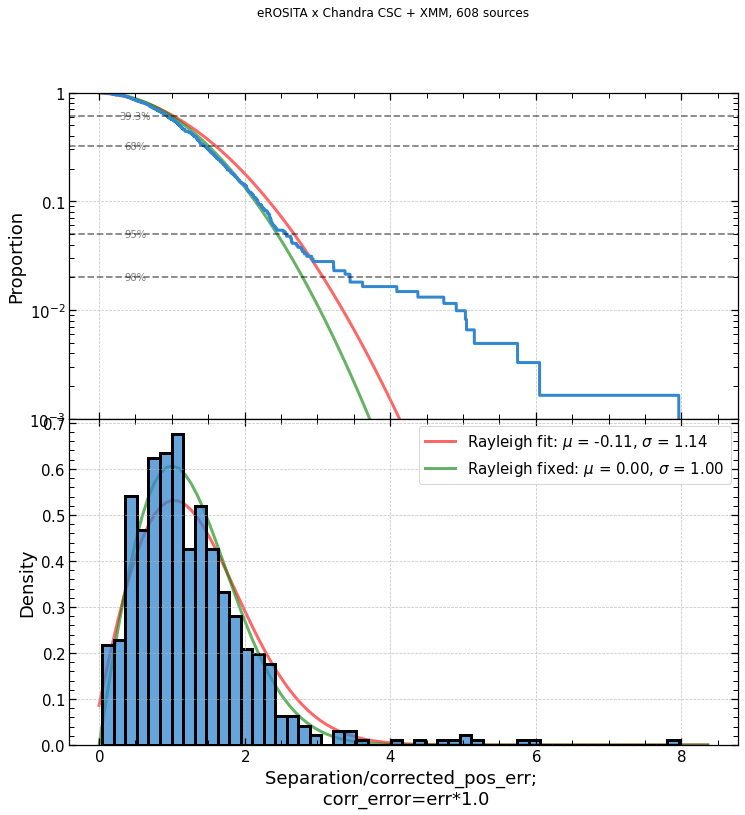

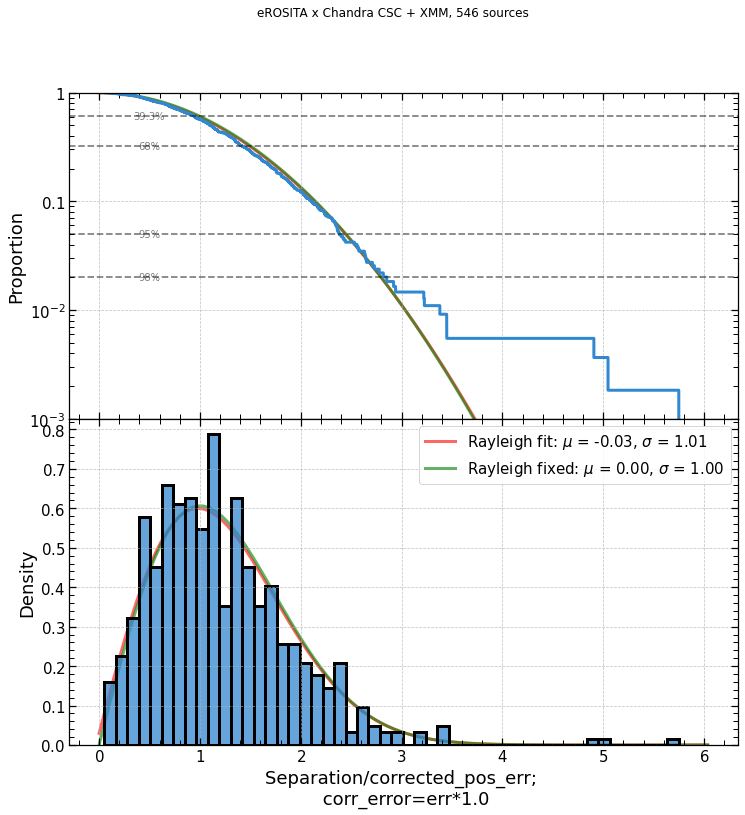

In [54]:
from scripts.cross_match_scripts import rayleigh_plot
rayleigh_plot(final_ctps, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')
rayleigh_plot(final_ctps_cut, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')



In [18]:
# old_companions = pd.read_pickle(data_path+'validation_ctps_ero_desi_lh.pkl')
# old_companions.ID = old_companions.ID.str.decode('utf-8')
# old_companions.desi_id_true_ctp = old_companions.desi_id_true_ctp.str.decode('utf-8')
# old_companions.rename(columns = {'ID':'srcname_fin', 'desi_id_true_ctp': 'desi_id'}, inplace = True)

# old_companions.sort_values(by='srcname_fin', inplace=True)
# old_companions.reset_index(drop=True, inplace=True)
# old_companions = old_companions[old_companions.desi_id!='hostless']

# # old_companions = old_companions.merge(desi[['ra', 'dec', 'desi_id']], on='desi_id', how='left')

# # old_companions = old_companions.merge(ero_df[['RA_fin', 'DEC_fin', 'pos_sigma_2d', 'srcname_fin']], on='srcname_fin', how='left')

# # old_companions = add_separation_columns(old_companions, colname_ra1 = 'RA_fin', colname_dec1 = 'DEC_fin', colname_ra2 = 'ra', colname_dec2 = 'dec', colname = 'sep_ero_desi')

# # old_companions

# # from scripts.cross_match_scripts import rayleigh_plot
# # rayleigh_plot(old_companions, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='old validation cat', pos_err_corr_func=lambda x: 0.9*x)
